Chapter 21

# 鸡兔猪蒙特卡罗模拟
Book_5《统计至简》 | 鸢尾花书：从加减乘除到机器学习 (第二版)

该代码利用贝叶斯推断估计三种动物（兔子、鸡、猪）的概率分布，并通过多项实验绘制后验分布的变化趋势。设定先验为Dirichlet分布，对观测数据逐步更新后验分布，最终展示出数据累积过程中参数估计的变化。

1. **生成观测数据**：使用 `numpy` 随机生成具有固定真实比例 \( \theta_{\text{true}} = [0.3, 0.6, 0.1] \) 的200个实验结果，每个实验结果为兔子、鸡或猪之一。

2. **数据预处理**：定义累积频率（cumsum）和比例（ratio）来计算每类动物的观测频率，数据存储在 `animal_df` 数据框中，以便后续绘图使用。

3. **数据可视化**：绘制了以下几种图像：
   - **实验结果可视化**：绘制动物类型在每次实验中的结果。
   - **频率图**：显示随着实验次数增加，不同动物比例逐渐收敛至真实值。
   - **柱状图**：展示实验次数随后的观测频率。

4. **后验分布计算与可视化**：基于Dirichlet-多项式模型，使用Beta分布表示每类动物的边缘后验分布。
   - **边缘后验的岭图**：展示随着实验次数变化的后验分布，并在不同实验次数下更新后验分布中的参数。
   - **后验分布快照**：选取不同实验次数的快照，计算每类动物在该时刻的边缘后验分布，用Beta分布表示。对于每一类动物，后验分布公式如下：
     $$
     p(\theta_i | \text{data}) = \text{Beta}(\alpha_i + \text{counts}_i, \alpha_0 + n - (\alpha_i + \text{counts}_i))
     $$

5. **Dirichlet分布的后验快照**：最后部分绘制Dirichlet分布在不同实验次数下的后验密度轮廓图，使用网格绘制不同类别的比例估计区域。

该代码展示了观测数据积累过程中后验分布从先验到收敛至真实值的变化，并且通过对不同实验次数的快照，逐步展示了贝叶斯更新的效果。

## 导入必要的库

In [1]:
import numpy as np  # 导入NumPy库用于数值计算
import pandas as pd  # 导入Pandas库用于数据处理
from matplotlib import pyplot as plt  # 导入matplotlib库中的pyplot模块用于绘图
import scipy.stats as stats  # 导入SciPy库中的stats模块用于统计计算

In [2]:
beta_dist = stats.beta  # 将Beta分布函数赋给变量beta_dist

## 生成随机数据

In [3]:
animal_choices = ['rabbit', 'chicken', 'piglet']  # 定义三种动物类型的列表
num_animals = 200  # 设置生成的动物样本数量为200
true_prob = [0.3, 0.6, 0.1]  # 设置每种动物出现的概率

animal_array = np.random.choice(animal_choices, num_animals, p=true_prob)  # 按照指定概率生成动物数据
animal_array = np.insert(animal_array, 0, 0)  # 在数据数组的最前面插入一个初始值0

# 创建DataFrame以存储动物数据，列名为'Animal'
animal_df = pd.DataFrame(data=animal_array, columns=['Animal'])

# 初始化三个标志列，表示不同动物类型，初始值均设为0
animal_df['x1_chicken'] = 0  # 鸡的标志列
animal_df['x2_rabbit'] = 0  # 兔子的标志列
animal_df['x3_piglet'] = 0  # 小猪的标志列

# 根据不同的动物类型，将对应标志列的值设为1
animal_df.loc[animal_df['Animal'] == 'chicken', 'x1_chicken'] = 1  # 鸡对应的标志列为1
animal_df.loc[animal_df['Animal'] == 'rabbit', 'x2_rabbit'] = 1  # 兔子对应的标志列为1
animal_df.loc[animal_df['Animal'] == 'piglet', 'x3_piglet'] = 1  # 小猪对应的标志列为1

# 设置绘图标记位列，用于不同动物类型的绘图位置
animal_df.loc[animal_df['Animal'] == 'chicken', 'x1_plot'] = 0  # 鸡的绘图位置为0
animal_df.loc[animal_df['Animal'] == 'rabbit', 'x2_plot'] = 1  # 兔子的绘图位置为1
animal_df.loc[animal_df['Animal'] == 'piglet', 'x3_plot'] = 2  # 小猪的绘图位置为2

# 计算每种动物的累计出现次数
animal_df['x1_cumsum'] = animal_df['x1_chicken'].cumsum()  # 累计出现的鸡数量
animal_df['x2_cumsum'] = animal_df['x2_rabbit'].cumsum()  # 累计出现的兔子数量
animal_df['x3_cumsum'] = animal_df['x3_piglet'].cumsum()  # 累计出现的小猪数量

# 计算每次试验结果的总标记值
animal_df['total_plot'] = animal_df[["x1_plot", "x2_plot", "x3_plot"]].sum(axis=1)

# 计算动物累计总数
animal_df['total'] = animal_df['x1_cumsum'] + animal_df['x2_cumsum'] + animal_df['x3_cumsum']

# 计算每种动物的比例
animal_df['x1_ratio'] = animal_df['x1_cumsum'] / animal_df['total']  # 鸡的出现比例
animal_df['x2_ratio'] = animal_df['x2_cumsum'] / animal_df['total']  # 兔子的出现比例
animal_df['x3_ratio'] = animal_df['x3_cumsum'] / animal_df['total']  # 小猪的出现比例

# 使用向前填充方法填补NaN值
animal_df[['x1_ratio', 'x2_ratio', 'x3_ratio']] = animal_df[['x1_ratio', 'x2_ratio', 'x3_ratio']].bfill()

## 可视化试验数据

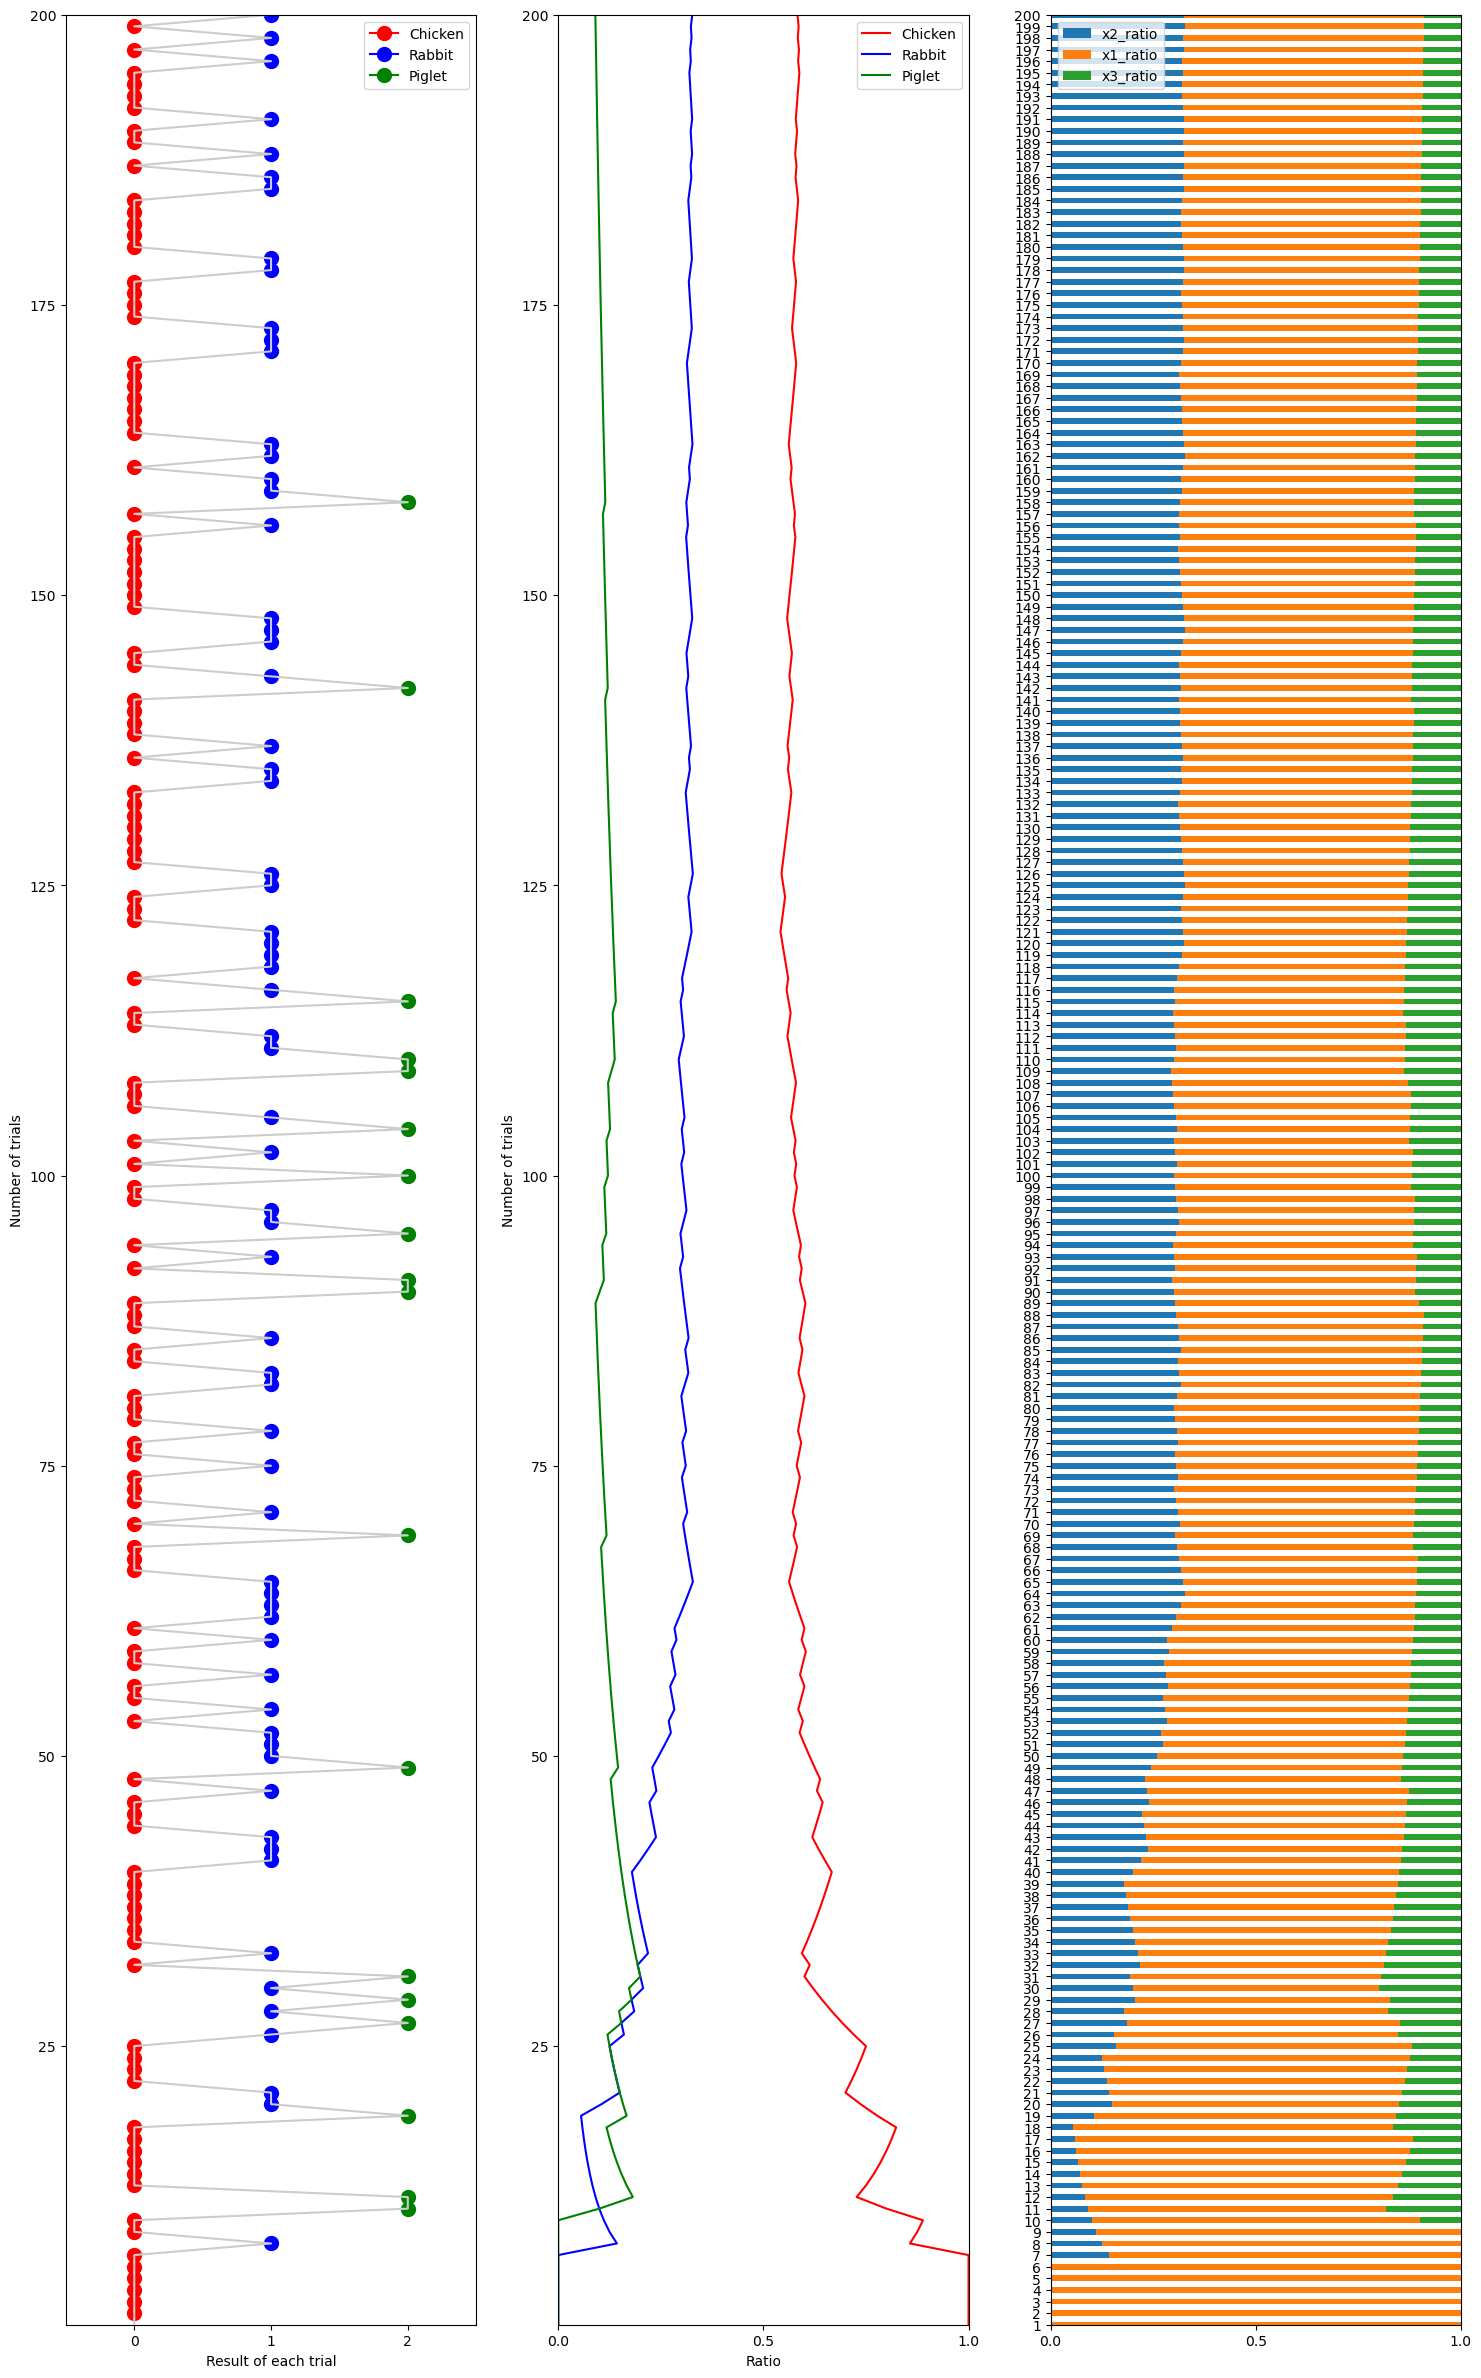

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 30))  # 创建一个包含3个子图的绘图窗口

trials_array = np.arange(0, 201) + 1  # 生成1到201的试验次数数组

# 绘制鸡的分布图，红色点表示
axs[0].plot(animal_df['x1_plot'], trials_array, color='r', marker='.', markersize=20, label='Chicken')

# 绘制兔子的分布图，蓝色点表示
axs[0].plot(animal_df['x2_plot'], trials_array, color='b', marker='.', markersize=20, label='Rabbit')

# 绘制小猪的分布图，绿色点表示
axs[0].plot(animal_df['x3_plot'], trials_array, color='g', marker='.', markersize=20, label='Piglet')

# 绘制所有动物总标记的灰色曲线
axs[0].plot(animal_df['total_plot'], trials_array, color=[0.8, 0.8, 0.8])

# 设置第一个子图的y轴范围和x轴范围
axs[0].set_ylim(1, 200)
axs[0].set_xlim(-0.5, 2.5)

# 设置x轴刻度
axs[0].set_xticks([0, 1, 2])

# 设置y轴标签
axs[0].set_ylabel("Number of trials", rotation=90)

# 设置x轴标签
axs[0].set_xlabel("Result of each trial")

# 添加图例
axs[0].legend()

# 绘制鸡的比例曲线，红色线表示
axs[1].plot(animal_df['x1_ratio'], trials_array, color='r', label='Chicken')

# 绘制兔子的比例曲线，蓝色线表示
axs[1].plot(animal_df['x2_ratio'], trials_array, color='b', label='Rabbit')

# 绘制小猪的比例曲线，绿色线表示
axs[1].plot(animal_df['x3_ratio'], trials_array, color='g', label='Piglet')

# 设置第二个子图的y轴范围和x轴范围
axs[1].set_ylim(1, 200)
axs[1].set_xlim(0, 1)

# 设置x轴刻度
axs[1].set_xticks([0, 0.5, 1])

# 设置y轴标签
axs[1].set_ylabel("Number of trials", rotation=90)

# 设置x轴标签
axs[1].set_xlabel("Ratio")

# 添加图例
axs[1].legend()

# 绘制每种动物比例的堆积条形图
animal_df[['x2_ratio', 'x1_ratio', 'x3_ratio']].plot.barh(stacked=True, ax=axs[2])

# 设置第三个子图的y轴范围和x轴范围
axs[2].set_ylim(1, 200)
axs[2].set_xlim(0, 1)

# 设置x轴刻度
axs[2].set_xticks([0, 0.5, 1])

## 设置先验参数 alpha

alpha_1 = 8  # 设置鸡的先验参数alpha_1
alpha_2 = 8  # 设置兔子的先验参数alpha_2
alpha_3 = 8  # 设置小猪的先验参数alpha_3

# 计算总先验参数alpha_0
alpha_0 = alpha_1 + alpha_2 + alpha_3

## 后验分布的连续变化

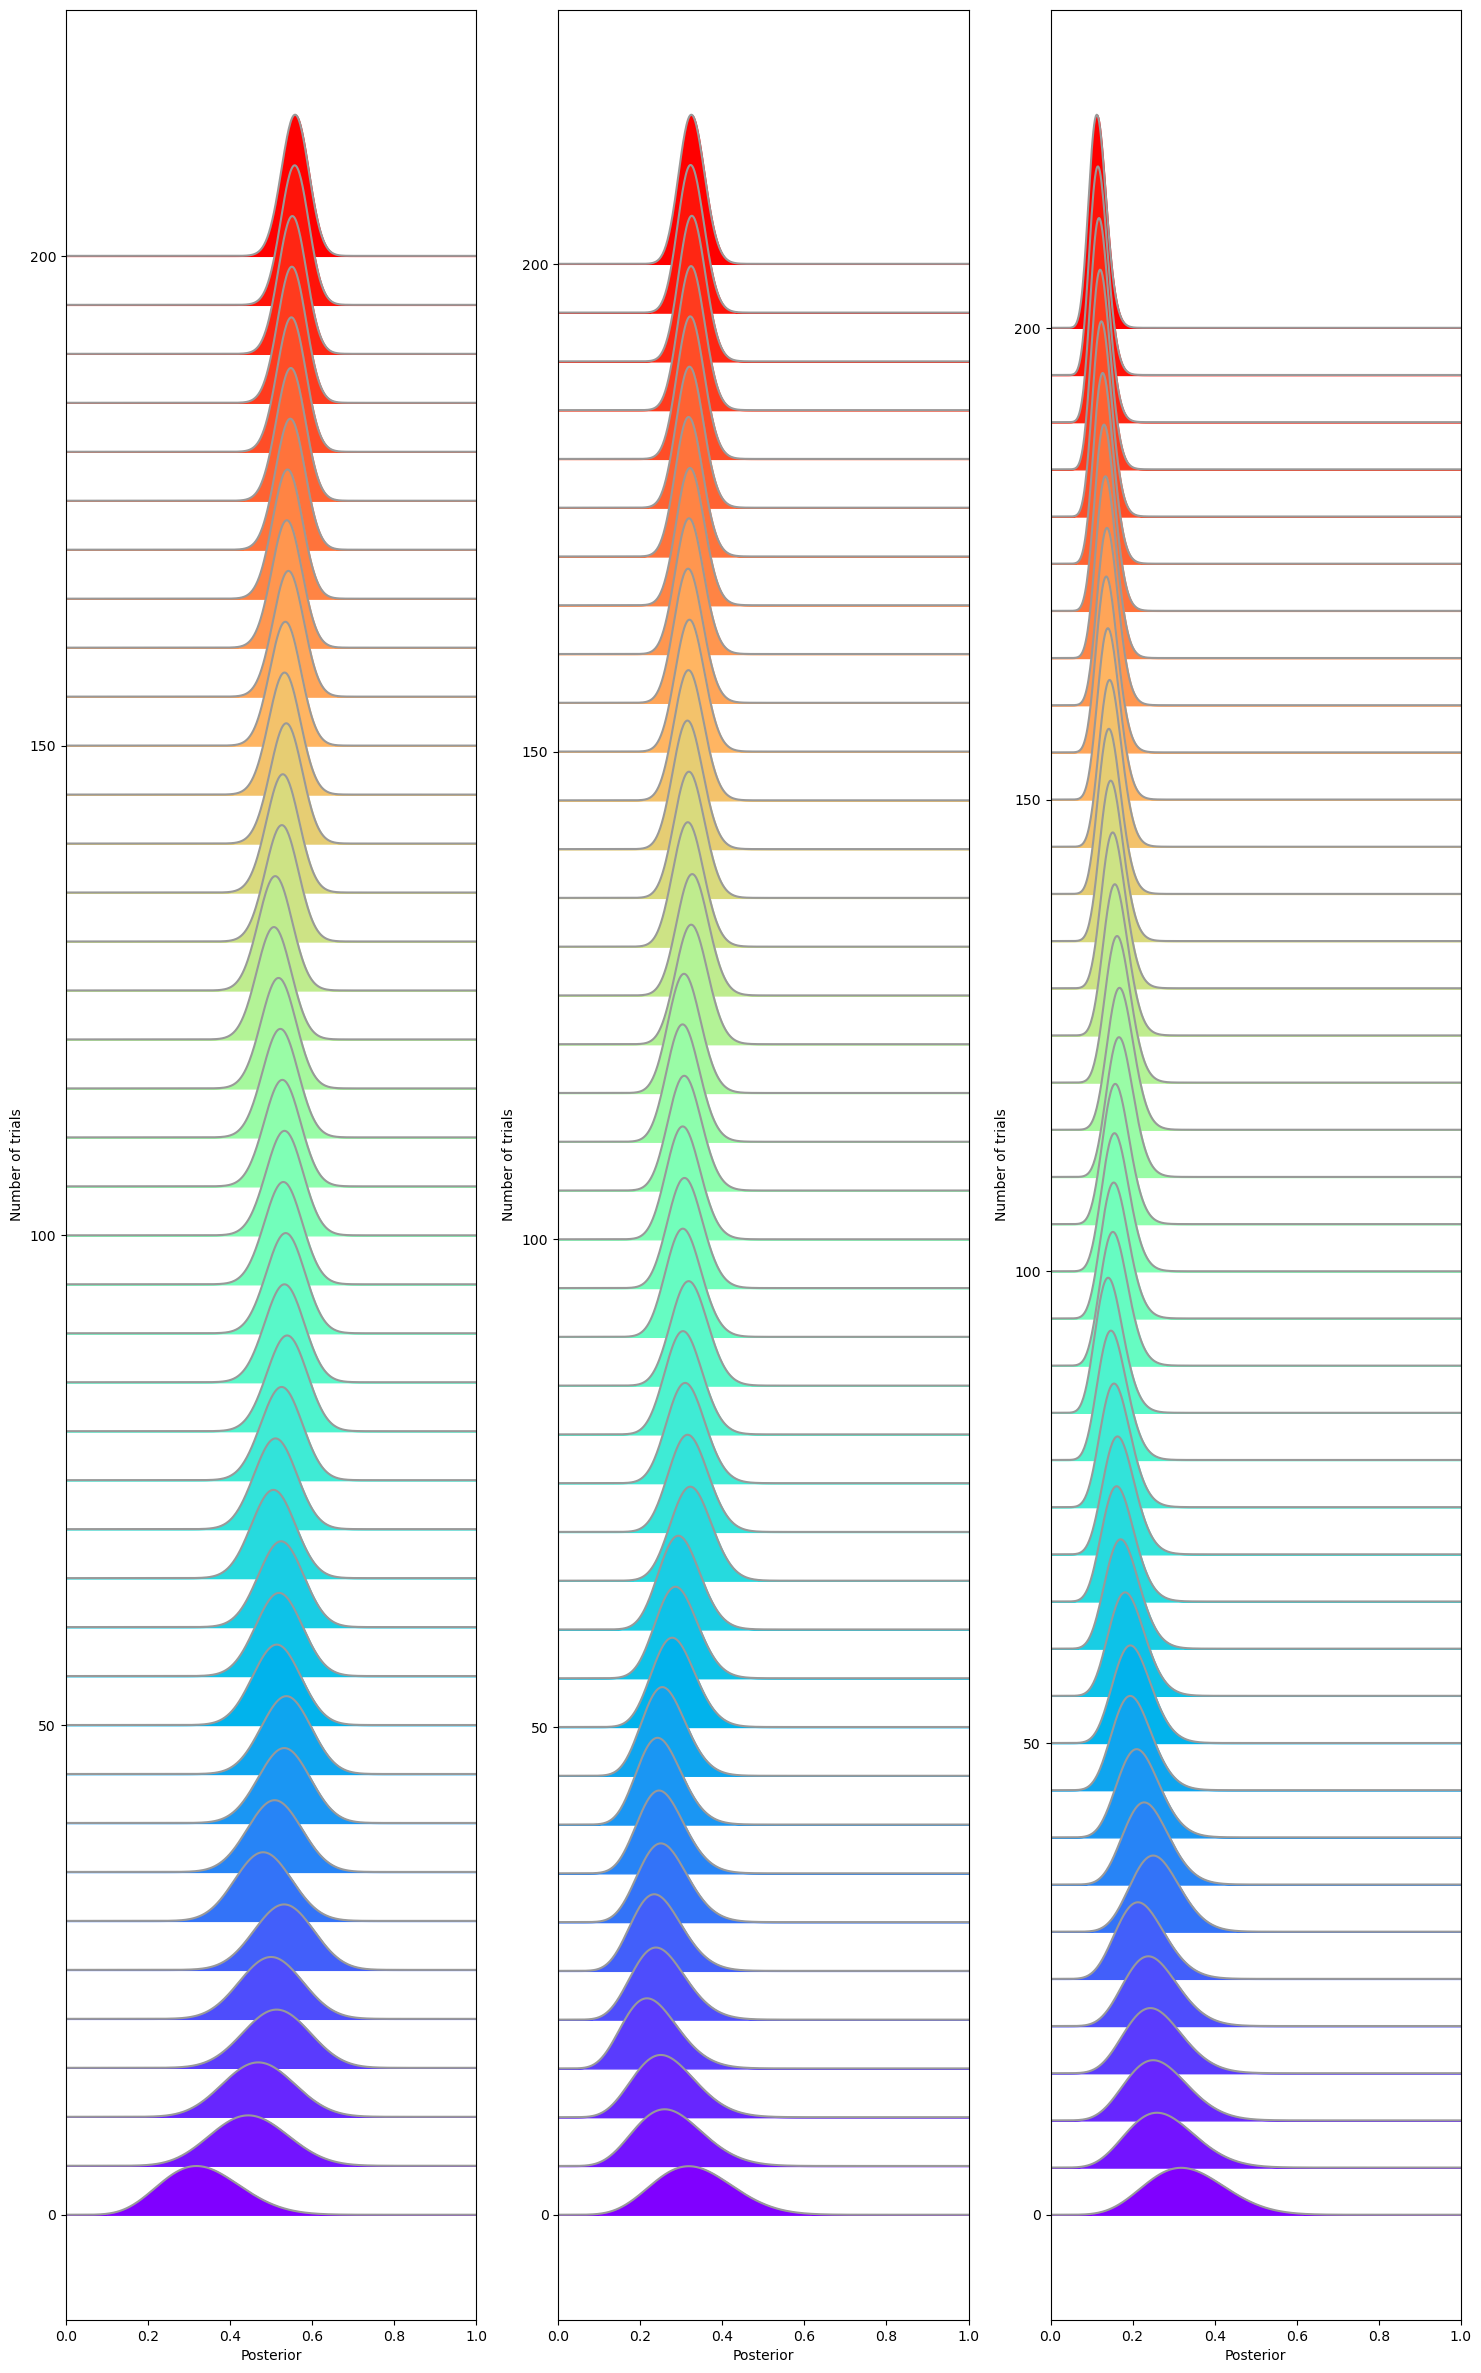

In [5]:
from matplotlib.pyplot import cm  # 导入cm模块用于生成颜色渐变

theta_array = np.linspace(0, 1, 500)  # 生成从0到1的500个θ值

num_animals_array = np.arange(0, 200 + 5, 5)[::-1]  # 生成试验数量数组，间隔为5，逆序排列

colors = cm.rainbow_r(np.linspace(0, 1, len(num_animals_array)))  # 生成颜色渐变的数组

# 创建包含3个子图的绘图窗口
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 30))

alphas = [alpha_1, alpha_2, alpha_3]  # 定义三种动物的先验参数alpha
x_3_choices = ['x1_cumsum', 'x2_cumsum', 'x3_cumsum']  # 累加列的名称

# 遍历不同的试验次数和累加数据
for ax_idx, alpha_prior_idx, x_idx in zip(axs.ravel(), alphas, x_3_choices):
    for idx, num_animals_idx in enumerate(num_animals_array):
        height = num_animals_idx  # 设置高度值
        num_chickens_idx = animal_df.iloc[num_animals_idx][x_idx]  # 获取当前试验数下的动物累积数量
        alpha_idx = alpha_prior_idx + num_chickens_idx  # 计算后验分布的alpha参数
        beta_idx = alpha_0 + num_animals_idx - alpha_idx  # 计算后验分布的beta参数
        posterior_pdf = beta_dist.pdf(theta_array, alpha_idx, beta_idx)  # 计算后验PDF值

        loc_max_1 = theta_array[np.argmax(posterior_pdf)]  # 获取后验分布最大位置
        ratio = 1.2  # 设置比例系数
        ax_idx.plot(theta_array, posterior_pdf * ratio + height, color=[0.6, 0.6, 0.6])  # 绘制后验分布曲线
        ax_idx.fill_between(theta_array, height, posterior_pdf * ratio + height, color=colors[idx])  # 填充曲线下方区域

    ax_idx.set_xlim(0, 1)  # 设置x轴范围
    ax_idx.set_xlabel('Posterior')  # 设置x轴标签
    ax_idx.set_ylabel('Number of trials')  # 设置y轴标签

## 后验曲线快照

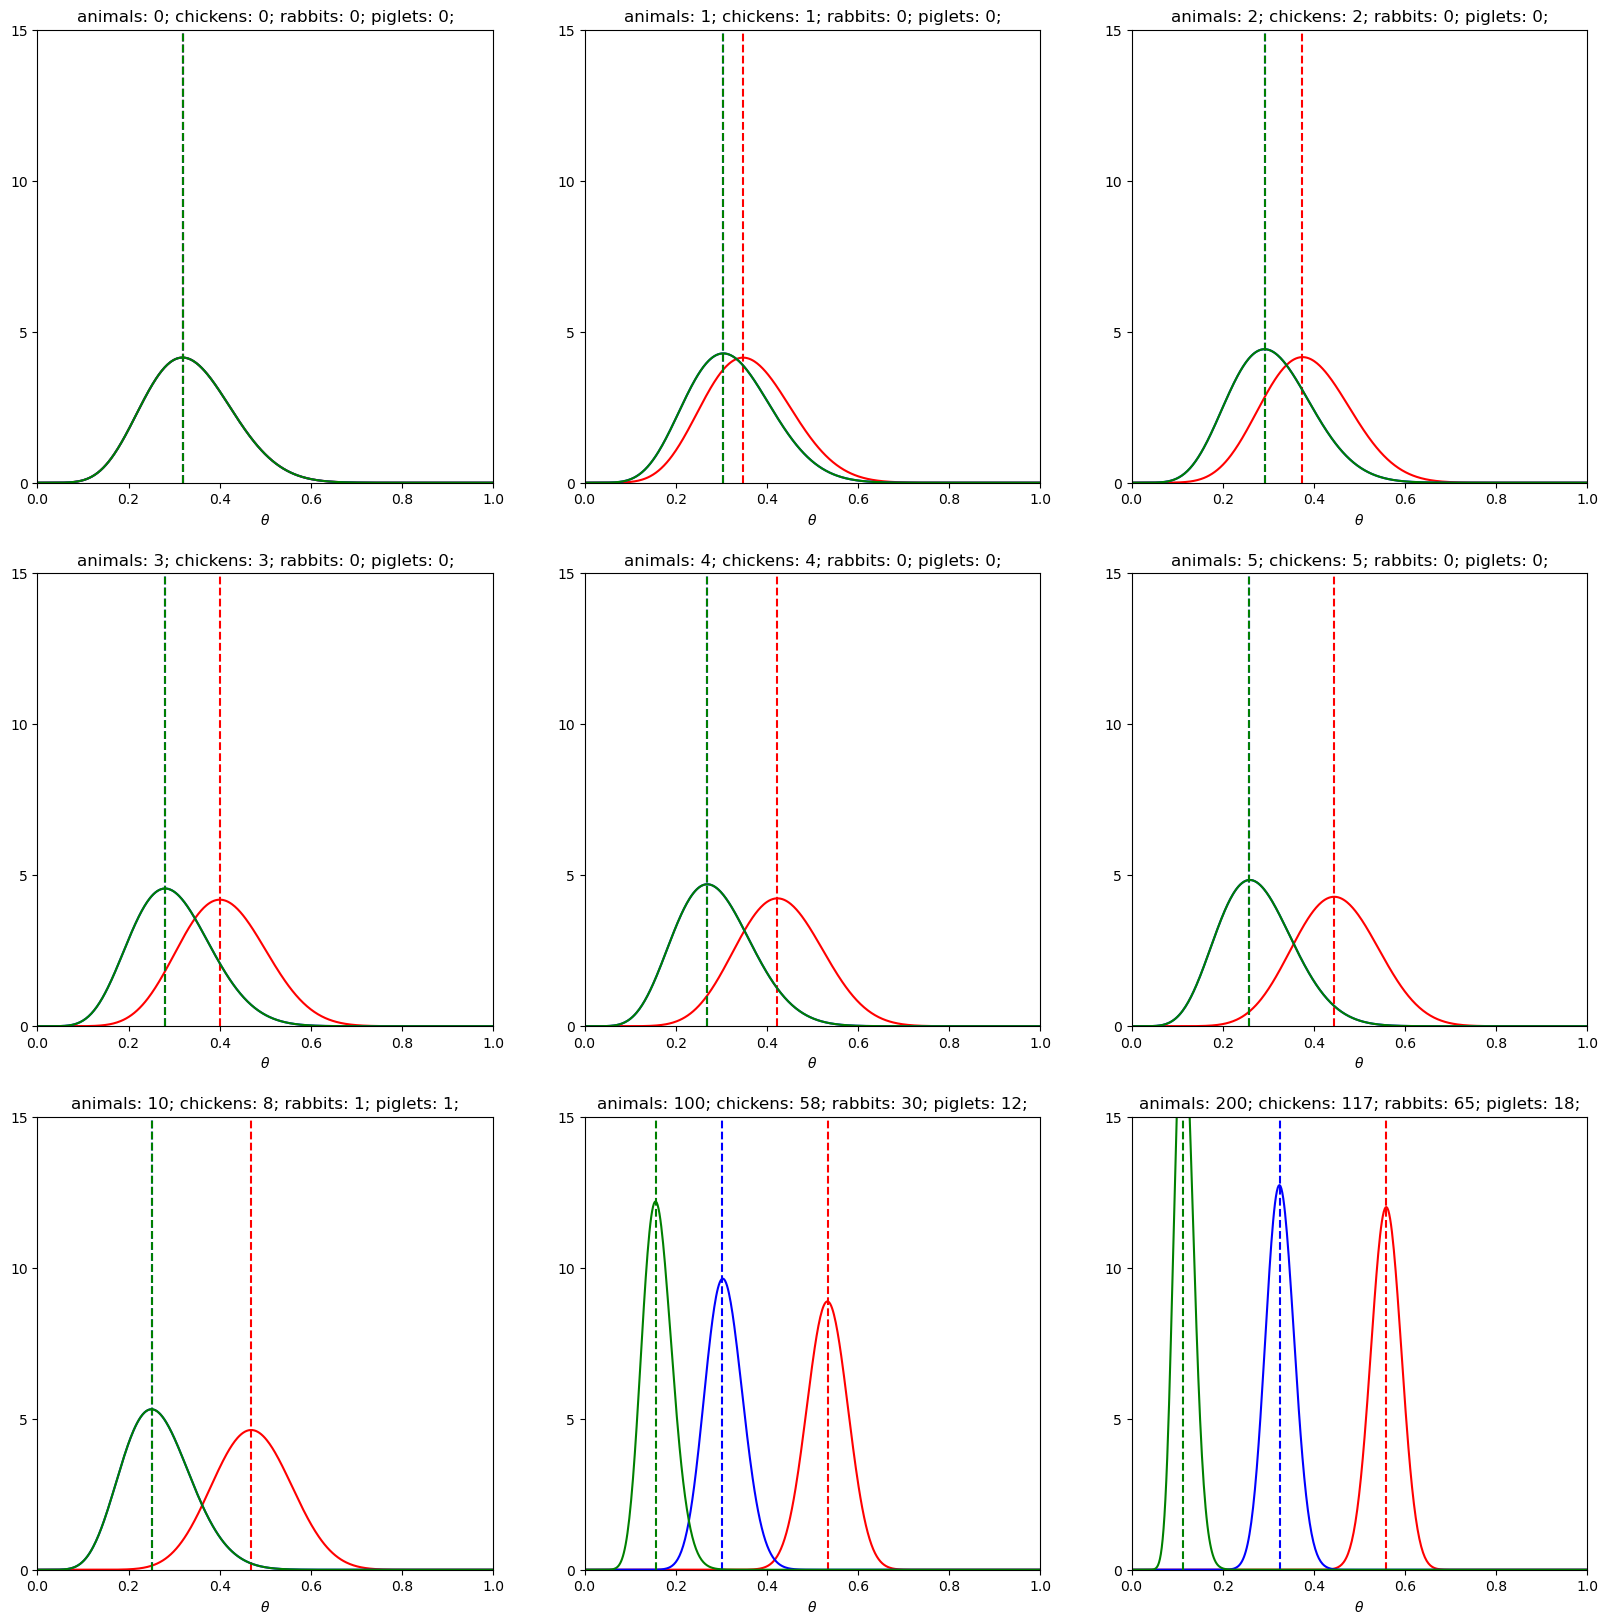

In [6]:
num_animals_array = [0, 1, 2, 3, 4, 5, 10, 100, 200]  # 定义不同试验次数的快照数组

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))  # 创建包含3x3个子图的图形窗口

# 逐次遍历不同试验次数绘制后验分布曲线
for ax_idx, num_animals_idx in zip(axs.ravel(), num_animals_array):
    num_chickens_idx = animal_df.iloc[num_animals_idx].x1_cumsum  # 获取当前试验数下鸡的累计数量
    num_rabbits_idx = animal_df.iloc[num_animals_idx].x2_cumsum  # 获取当前试验数下兔子的累计数量
    num_piglets_idx = animal_df.iloc[num_animals_idx].x3_cumsum  # 获取当前试验数下小猪的累计数量

    # 计算鸡的后验分布
    alpha_1_idx = alpha_1 + num_chickens_idx  # 鸡的后验alpha
    beta_1_idx = alpha_0 + num_animals_idx - alpha_1_idx  # 鸡的后验beta
    posterior_pdf_1 = beta_dist.pdf(theta_array, alpha_1_idx, beta_1_idx)  # 计算鸡的后验PDF
    loc_max_1 = theta_array[np.argmax(posterior_pdf_1)]  # 获取后验最大位置
    ax_idx.plot(theta_array, posterior_pdf_1, color='r')  # 绘制鸡的后验分布曲线
    ax_idx.axvline(x=loc_max_1, color='r', linestyle='--')  # 绘制鸡的最大位置虚线

    # 计算兔子的后验分布
    alpha_2_idx = alpha_2 + num_rabbits_idx  # 兔子的后验alpha
    beta_2_idx = alpha_0 + num_animals_idx - alpha_2_idx  # 兔子的后验beta
    posterior_pdf_2 = beta_dist.pdf(theta_array, alpha_2_idx, beta_2_idx)  # 计算兔子的后验PDF
    loc_max_2 = theta_array[np.argmax(posterior_pdf_2)]  # 获取兔子的最大位置
    ax_idx.plot(theta_array, posterior_pdf_2, color='b')  # 绘制兔子的后验分布曲线
    ax_idx.axvline(x=loc_max_2, color='b', linestyle='--')  # 绘制兔子的最大位置虚线

    # 计算小猪的后验分布
    alpha_3_idx = alpha_3 + num_piglets_idx  # 小猪的后验alpha
    beta_3_idx = alpha_0 + num_animals_idx - alpha_3_idx  # 小猪的后验beta
    posterior_pdf_3 = beta_dist.pdf(theta_array, alpha_3_idx, beta_3_idx)  # 计算小猪的后验PDF
    loc_max_3 = theta_array[np.argmax(posterior_pdf_3)]  # 获取小猪的最大位置
    ax_idx.plot(theta_array, posterior_pdf_3, color='g')  # 绘制小猪的后验分布曲线
    ax_idx.axvline(x=loc_max_3, color='g', linestyle='--')  # 绘制小猪的最大位置虚线

    ax_idx.set_xlabel('$\\theta$')  # 设置x轴标签
    ax_idx.set_xlim(0, 1)  # 设置x轴范围
    ax_idx.set_yticks([0, 5, 10, 15])  # 设置y轴刻度
    ax_idx.set_ylim(0, 15)  # 设置y轴范围
    ax_idx.set_title("animals: %d; chickens: %d; rabbits: %d; piglets: %d;" % (num_animals_idx, num_chickens_idx, num_rabbits_idx, num_piglets_idx))  # 设置子图标题

## Dirichlet分布的快照

In [7]:
# 定义 x1 和 x2 为 0 到 1 范围内的 201 个点，用于生成网格
x1 = np.linspace(0, 1, 201)
x2 = np.linspace(0, 1, 201)

# 生成 x1 和 x2 的二维网格
xx1, xx2 = np.meshgrid(x1, x2)

# 计算第三个比例 xx3 使得三者和为 1，并将不满足该条件的值置为 NaN
xx3 = 1.0 - xx1 - xx2
xx3 = np.where(xx3 > 0.0, xx3, np.nan)

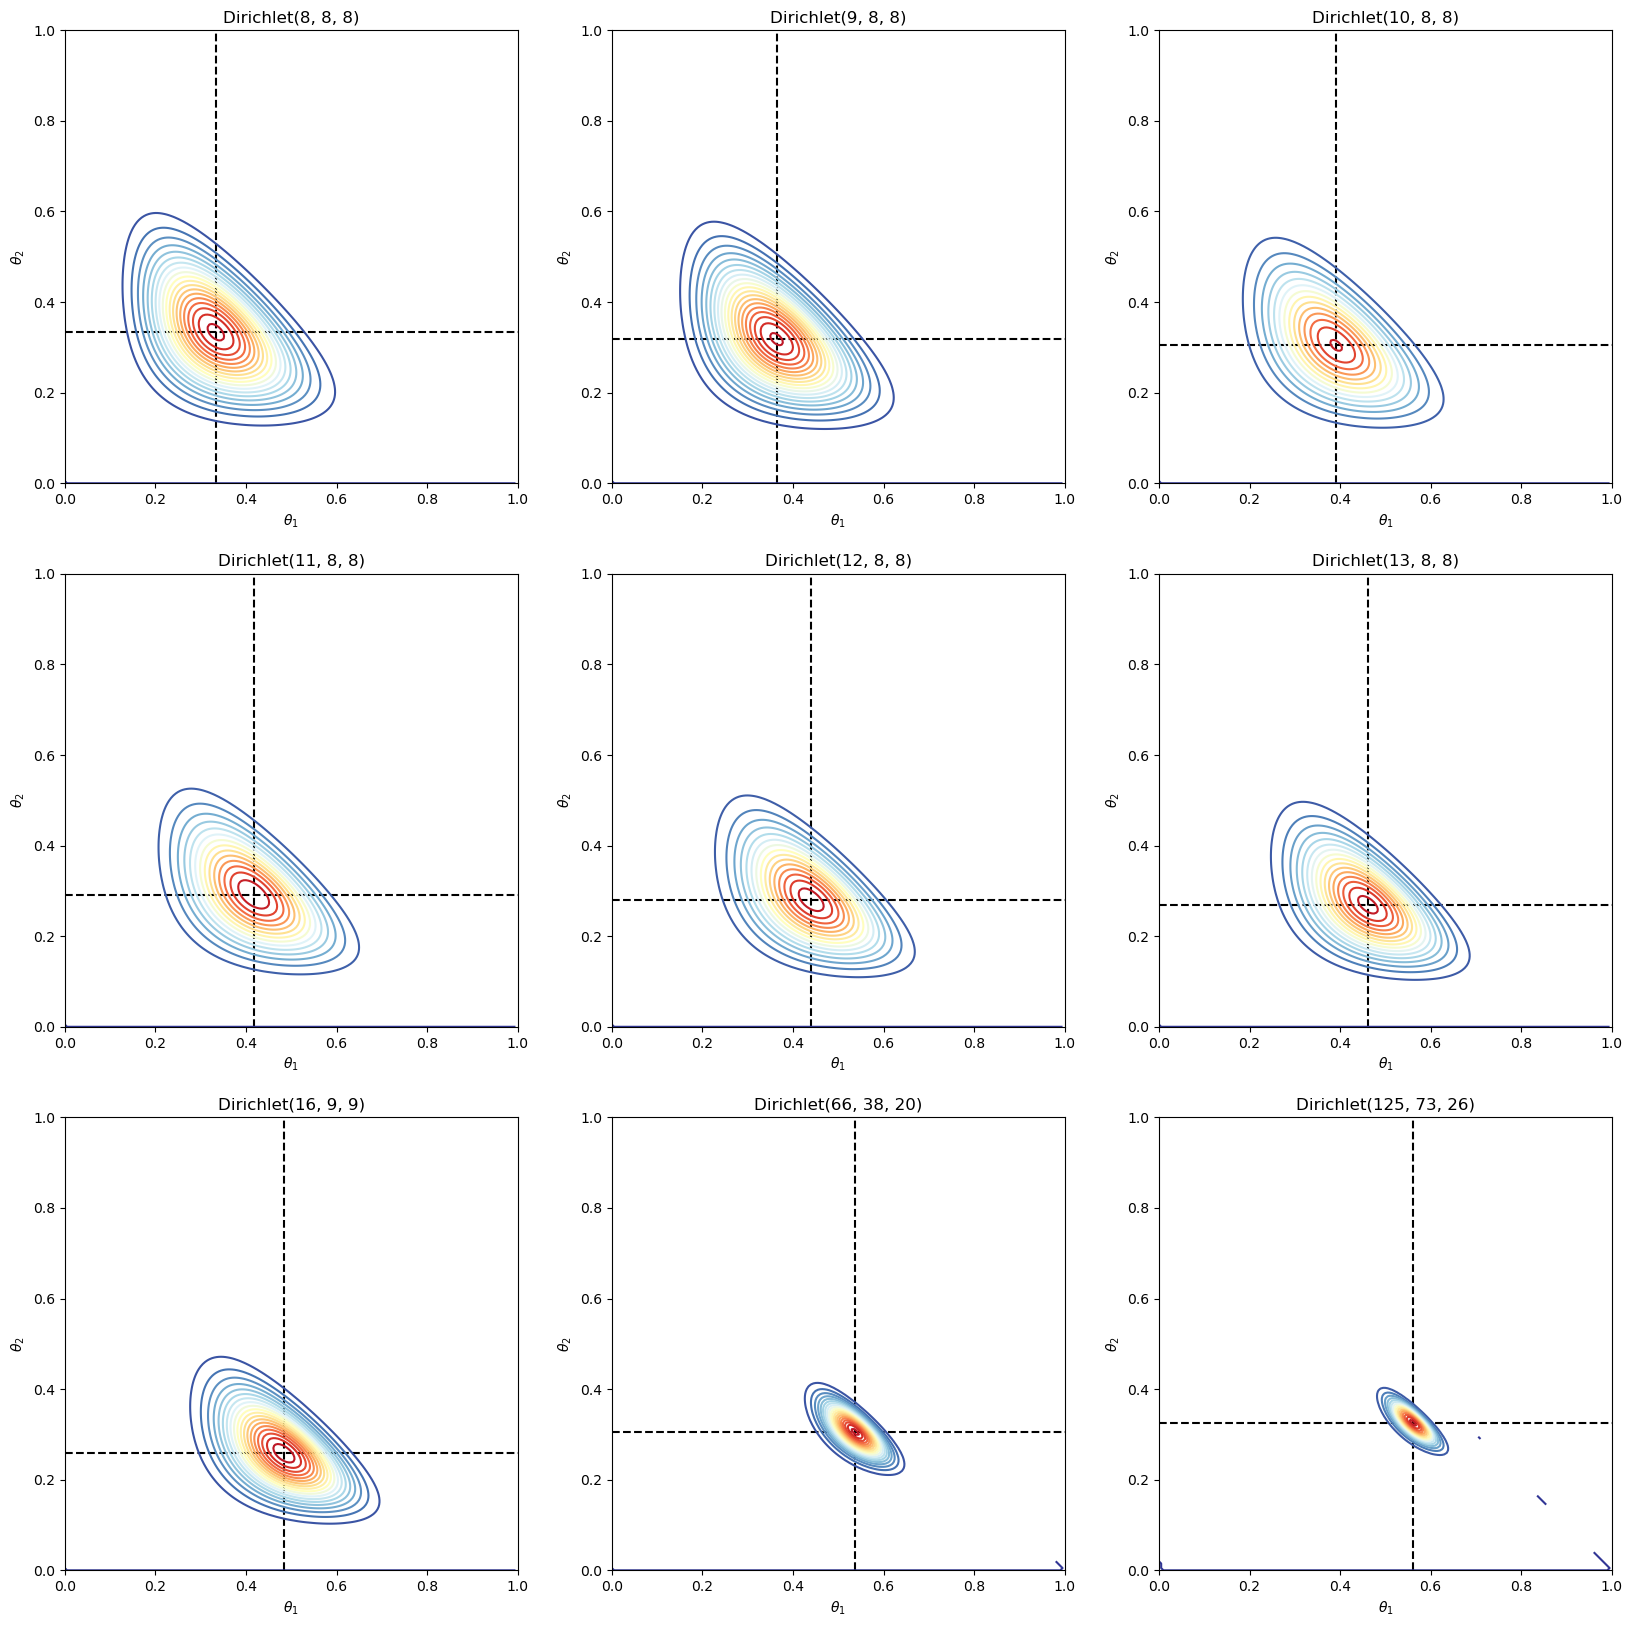

In [8]:
# 创建 3x3 的子图布局用于显示不同实验次数的 Dirichlet 分布快照
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

# 遍历每个子图和对应的实验数量
for ax_idx, num_animals_idx in zip(axs.ravel(), num_animals_array):
    
    # 获取当前实验数量对应的累计鸡、兔子、猪数量
    num_chickens_idx = animal_df.iloc[num_animals_idx].x1_cumsum
    num_rabbits_idx  = animal_df.iloc[num_animals_idx].x2_cumsum
    num_piglets_idx  = animal_df.iloc[num_animals_idx].x3_cumsum
    
    # 获取当前实验数量的总观测数
    n = animal_df.iloc[num_animals_idx].total
    
    # 更新 Dirichlet 分布的参数（即后验参数），包括鸡、兔子和猪
    alpha_1_idx = alpha_1 + num_chickens_idx
    alpha_2_idx = alpha_2 + num_rabbits_idx
    alpha_3_idx = alpha_3 + num_piglets_idx
    
    # 设置子图标题，标记 Dirichlet 分布的参数组合
    title_txt = 'Dirichlet(%0.0f, %0.0f, %0.0f)' % (alpha_1_idx, alpha_2_idx, alpha_3_idx)
    
    # 计算当前 alpha 值的 Dirichlet 分布概率密度函数
    alphas = np.array([alpha_1_idx, alpha_2_idx, alpha_3_idx])
    rv = stats.dirichlet(alphas)
    PDF_ff = rv.pdf(np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()]))
    PDF_ff = np.reshape(PDF_ff, xx1.shape)
    
    # 计算后验模式（即最大后验概率点）的 θ1 和 θ2 位置
    theta_1_mode = (alpha_1 + num_chickens_idx - 1) / (alpha_0 + n - 3)
    theta_2_mode = (alpha_2 + num_rabbits_idx - 1) / (alpha_0 + n - 3)
    
    # 在子图中添加 θ1 和 θ2 的模式虚线位置
    ax_idx.axvline(x=theta_1_mode, color='k', ls='--')
    ax_idx.axhline(y=theta_2_mode, color='k', ls='--')
    
    # 绘制 Dirichlet 分布的概率密度等高线
    ax_idx.contour(xx1, xx2, PDF_ff, 20, cmap='RdYlBu_r')
    ax_idx.set_xlabel(r'$\theta_1$')  # 横坐标标签 θ1
    ax_idx.set_ylabel(r'$\theta_2$')  # 纵坐标标签 θ2
    ax_idx.set_box_aspect(1)         # 设置子图为方形
    ax_idx.set_title(title_txt)      # 设置子图标题